In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(
    "data/2022/Divvy_Trips_2022_full.csv.gz",
    compression="gzip",
    parse_dates=["started_at", "ended_at"],
)

In [3]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012800,-87.665906,42.012560,-87.674367,casual
1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012763,-87.665967,42.012560,-87.674367,casual
2,BD0F91DFF741C66D,classic_bike,2022-01-25 04:53:40,2022-01-25 04:58:01,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,41.925602,-87.653708,41.925330,-87.665800,member
3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,41.983593,-87.669154,41.961507,-87.671387,casual
4,DDC963BFDDA51EEA,classic_bike,2022-01-20 01:31:10,2022-01-20 01:37:12,Michigan Ave & Jackson Blvd,TA1309000002,State St & Randolph St,TA1305000029,41.877850,-87.624080,41.884621,-87.627834,member


In [4]:
# Фильтруем датасет: строчки с началом позже конца и с пустыми значениями начала/конца не нужны
df = df[df["started_at"] < df["ended_at"]]
df = df.dropna(subset=["started_at", "ended_at"])

In [5]:
# Создаем датасеты с началами и концами поездок и соответственно присваиваем значения
start_time = pd.DataFrame(df["started_at"])
start_time["result"] = 1

end_time = pd.DataFrame(df["ended_at"])
end_time["result"] = -1

In [6]:
# Меняем названия колонок, чтобы склеить в один датасет
start_time = start_time.rename(columns={"started_at": "time"})
end_time = end_time.rename(columns={"ended_at": "time"})

result = pd.concat([end_time, start_time])

In [7]:
# Сортируем значения по времени
result = result.sort_values(by=["time"])

In [8]:
# Создаем поле дня, часа и дня-часа
result["day"] = result["time"].dt.date.astype(str)
result["hour"] = result["time"].dt.hour.astype(str)
result["day_hour"] = result["day"] + " " + result["hour"]

# Переводим час к цифровому типу чтобы не ломать сортировку позже
result["hour"] = result["hour"].astype(int)

In [9]:
result.head()

,time,result,day,hour,day_hour
73479,2022-01-01 00:00:05,1,2022-01-01,0,2022-01-01 0
68510,2022-01-01 00:01:00,1,2022-01-01,0,2022-01-01 0
64490,2022-01-01 00:01:16,1,2022-01-01,0,2022-01-01 0
73479,2022-01-01 00:01:48,-1,2022-01-01,0,2022-01-01 0
73485,2022-01-01 00:02:14,1,2022-01-01,0,2022-01-01 0


In [10]:
# Группируем по колонке день-час
groped_df = result.groupby("day_hour", group_keys=True).apply(lambda x: x)

In [11]:
# Создаем колонку со значениями прошлое значение колонки + значение ['result'], таким образом получаем количество активных поездок
groped_df["sum"] = groped_df["result"].cumsum()

In [12]:
# Убираем ненужную колонку result для экономии памяти
groped_df.drop(columns=["result"], inplace=True)

In [13]:
# Переводим день в формат даты
groped_df["day"] = pd.to_datetime(groped_df["day"])

In [14]:
# Создаем сводную таблицу, получаем максимальную нагрузку за каждый час по дням
table = pd.pivot_table(
    groped_df, values="sum", index="day", columns="hour", aggfunc=np.max
)

In [15]:
table.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
2022-01-01,68.0,99.0,61.0,12.0,-6.0,-25.0,-20.0,-11.0,-8.0,12.0,...,78.0,75.0,75.0,69.0,68.0,67.0,25.0,26.0,21.0,23.0
2022-01-02,12.0,13.0,18.0,4.0,0.0,2.0,5.0,7.0,20.0,22.0,...,36.0,69.0,56.0,45.0,30.0,23.0,21.0,13.0,11.0,7.0
2022-01-03,17.0,11.0,7.0,-14.0,-13.0,-1.0,10.0,30.0,23.0,23.0,...,26.0,43.0,50.0,64.0,40.0,27.0,6.0,1.0,-3.0,-9.0
2022-01-04,14.0,13.0,23.0,-22.0,-18.0,-3.0,17.0,48.0,52.0,28.0,...,35.0,55.0,76.0,94.0,60.0,48.0,23.0,4.0,-7.0,-12.0
2022-01-05,19.0,20.0,13.0,3.0,5.0,19.0,41.0,50.0,53.0,44.0,...,14.0,27.0,40.0,38.0,38.0,21.0,12.0,2.0,-4.0,1.0


In [16]:
# Посмотрим на графике как менялась максимальная нагрузка по дням за январь
table = table.loc[
    (table.index > datetime(2022, 1, 1)) & (table.index < datetime(2022, 1, 31))
]
table["max_for_day"] = table.max(axis=1)

In [21]:
plt.plot(table.index, table["max_for_day"])
plt.xticks(rotation=45)
plt.ylabel("Максимальная нагрузка за день")
plt.xlabel("День")
plt.grid()
plt.title("Максимальная нагрузка за день в феврале")

KeyError: 'max_for_day'

In [18]:
# Другой тип сводной таблицы - среднее по каждому часу
table = pd.pivot_table(groped_df, values="sum", index=["hour"], aggfunc=np.mean)

In [19]:
table.head()

,sum
hour,
0,206.045620
1,161.745107
2,247.857254
3,0.806433
4,-9.000177


Text(0.5, 1.0, 'Среднее изменение активных поездок в час')

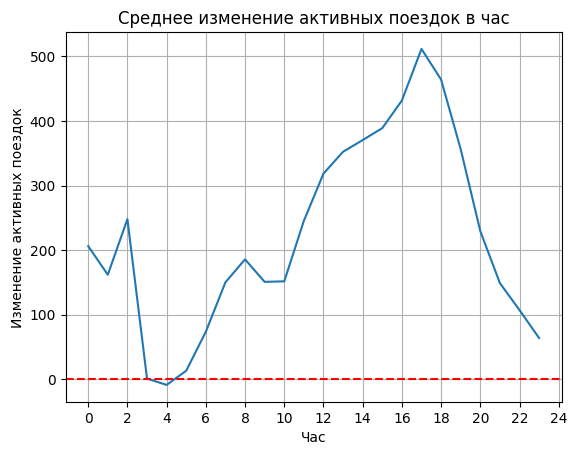

In [22]:
plt.plot(table.index, table.values)
plt.xlabel("Час")
plt.ylabel("Изменение активных поездок")
plt.grid()
plt.axhline(y=0, color="r", linestyle="--")
plt.xticks(range(0, 25, 2))
plt.title("Среднее изменение активных поездок в час")